In [144]:
%load_ext autoreload
%autoreload 2

import re

import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Columns statistics

In [146]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [147]:
train_df[['text']].describe()

,text
count,7613
unique,7503
top,11-Year-Old Boy Charged With Manslaughter of T...
freq,10


## Preprocessing stats

In [148]:
# TODO to consider
# stopwords removal
# punctuation removal
# tokenization verification

EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)

train_df[:3]

,id,keyword,location,text,target,text_preproc
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...


In [150]:
test_df['text_preproc'] = test_df['text'].apply(_preprocessing)

test_df[:3]

,id,keyword,location,text,text_preproc
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...


In [151]:
def _count(txt: str) -> int:
    return len(txt.split(' '))

train_df['text_length'] = train_df['text'].apply(_count)
test_df['text_length'] = test_df['text'].apply(_count)

train_df[:3]

,id,keyword,location,text,target,text_preproc,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,22


In [152]:
train_positive = train_df.loc[train_df['target'] == 1]
train_negative = train_df.loc[train_df['target'] == 0]

len(train_positive), len(train_negative)

(3271, 4342)

In [153]:
def _count_occurrences(data:str, field: str) -> str:
    results = {}
    for t in data.itertuples():
        l = getattr(t, field)
        if t.text_length in results:
            results[l] += 1
        else:
            results[l] = 0
    return results

positive_lengths = _count_occurrences(train_positive, 'text_length')
negative_lengths = _count_occurrences(train_negative, 'text_length')
test_lengths = _count_occurrences(test_df, 'text_length')

count    3271.000000
mean       15.201162
std         5.184417
min         2.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        54.000000
Name: text_length, dtype: float64
count    4342.000000
mean       14.723860
std         6.188171
min         1.000000
25%        10.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length, dtype: float64


Text(0.5, 0.98, 'Text lengths')

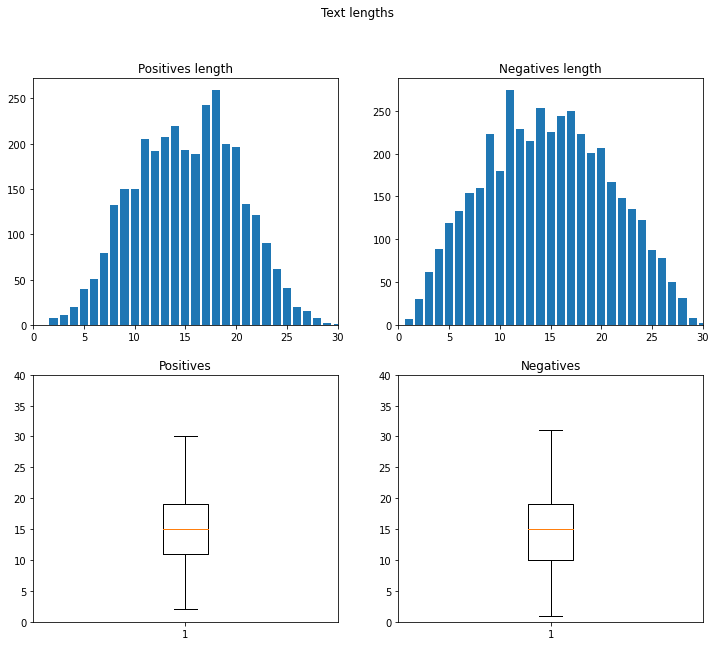

In [154]:
positive_names = list(positive_lengths.keys())
positive_values = list(positive_lengths.values())

negative_names = list(negative_lengths.keys())
negative_values = list(negative_lengths.values())

negatives_df = train_df.loc[train_df['target'] == 0]
positives_df = train_df.loc[train_df['target'] == 1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
ax1.set_title('Positives length')
ax1.set_xlim([0, 30])
ax1.bar(positive_names, positive_values)
ax2.set_title('Negatives length')
ax2.set_xlim([0, 30])
ax2.bar(negative_names, negative_values)

ax3.set_title('Positives')
ax3.set_ylim([0, 40])
ax3.boxplot(positives_df['text_length'])
print(positives_df['text_length'].describe())

ax4.set_title('Negatives')
ax4.set_ylim([0, 40])
ax4.boxplot(negatives_df['text_length'])
print(negatives_df['text_length'].describe())

fig.suptitle('Text lengths')

### Tokens distribution in 2d space

count    3263.000000
mean       14.978854
std         5.814619
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        34.000000
Name: text_length, dtype: float64


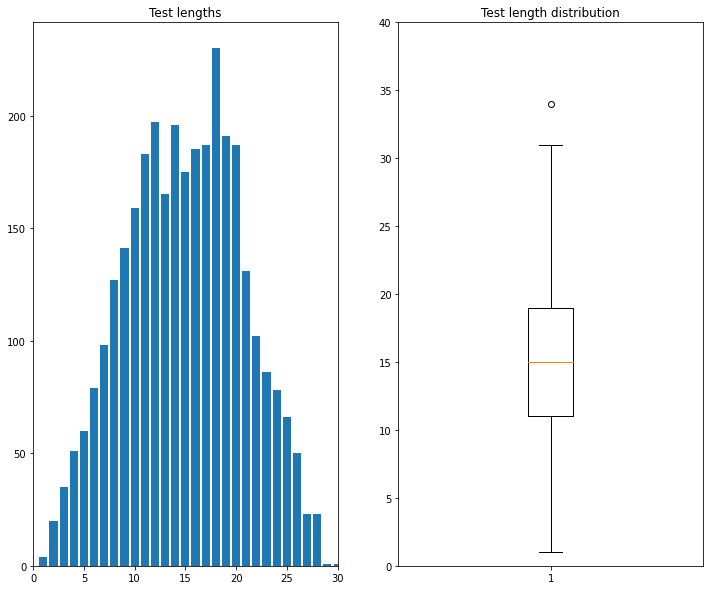

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
ax1.set_title('Test lengths')
ax1.set_xlim([0, 30])
ax1.bar(list(test_lengths.keys()), list(test_lengths.values()))

ax2.set_title('Test length distribution')
ax2.set_ylim([0, 40])
ax2.boxplot(test_df['text_length'])

print(test_df['text_length'].describe())

In [ ]:
def plot_2d_space(X, y, label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.gcf().set_size_inches((20, 20))
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

X = train_df['text_preproc']
y = train_df['target']

vec = TfidfVectorizer(min_df=2, max_df=0.1)
vec.fit(X)
X_vec = vec.transform(X)

sgd = TruncatedSVD (n_components=2)
X = sgd.fit_transform(X_vec)

plot_2d_space(X, y, '[Original tokens] Dataset (2 PCA components)')

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.pipeline

In [ ]:
# disable not used parts of pipeline

def _lemma(txt: str) -> str:
    return ' '.join([d.lemma_ for d in nlp(txt)])

train_df['text_preproc_lemma'] = train_df['text_preproc'].apply(_lemma)
train_df['text_preproc_lemma']

In [ ]:
X = train_df['text_preproc_lemma']
y = train_df['target']

vec = TfidfVectorizer(min_df=2, max_df=0.1)
vec.fit(X)
X_vec = vec.transform(X)

sgd = TruncatedSVD (n_components=2)
X = sgd.fit_transform(X_vec)

plot_2d_space(X, y, '[Lemmatization] Dataset (2 PCA components)')

### Tokens saturation from training set in test set

In [ ]:
X = train_df['text_preproc']
y = train_df['target']

vec_train = TfidfVectorizer(min_df=2, max_df=0.1)
vec_train.fit(X)
